### **Importation des librairies**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
#from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample

%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split



### **Importation des données** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train_Tr=pd.read_csv("/content/drive/My Drive/ML_Projet_MCNS/train_transaction.csv")
df_train_identity=pd.read_csv("/content/drive/My Drive/ML_Projet_MCNS/train_identity.csv")
df_test_id=pd.read_csv("/content/drive/My Drive/ML_Projet_MCNS/test_identity.csv")
df_test_Tr=pd.read_csv("/content/drive/My Drive/ML_Projet_MCNS/test_transaction.csv")

In [ ]:
train= df_train_Tr.merge(df_train_identity, how='left', on="TransactionID")
test = df_test_Tr.merge(df_test_id, how='left', on="TransactionID")

## **Description des données**


Information of Variables

###  **From Transaction table**
#### **Numeric Variables**

**TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)

**TransactionAMT**: transaction payment amount in USD

**dist**: May be the distance from addresses

**C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

**D1-D15**: timedelta, such as days between previous transaction, etc.

**V1 - V339**: Vesta engineered rich features, including ranking, counting, and other entity relations.

**id_01 - id_11**(In identity table)

### **Categorical Variables**

## From identity table
**ProductCD**: product code, the product for each transaction

**card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.

**addr1, addr2**: both are for purchaser, addr1 as billing region, addr2 as billing country

**Pemaildomain, Remaildomain**: purchaser and recipient email domain

**M1 - M9**: match, such as names on card and address, etc.

## From Identity Table:

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners.

**id12 - id38, DeviceType, DeviceInfo**

In [ ]:
print("The shape of train is: %s, %s" % (train.shape[0],train.shape[1]))
print("The shape of test is: %s, %s" % (test.shape[0],test.shape[1]))

The shape of train is: 590540, 434
The shape of test is: 506691, 433


In [ ]:
train.describe()

TransactionID        isFraud  ...        id_26         id_32
count   5.905400e+05  590540.000000  ...  5163.000000  77586.000000
mean    3.282270e+06       0.034990  ...   149.070308     26.508597
std     1.704744e+05       0.183755  ...    32.101995      3.737502
min     2.987000e+06       0.000000  ...   100.000000      0.000000
25%     3.134635e+06       0.000000  ...   119.000000     24.000000
50%     3.282270e+06       0.000000  ...   149.000000     24.000000
75%     3.429904e+06       0.000000  ...   169.000000     32.000000
max     3.577539e+06       1.000000  ...   216.000000     32.000000

[8 rows x 403 columns]

## **Analyse Exploratoire des données** 

### **Renommer des colonnes**

In [ ]:
def differentcolumns(traincols, testcols):
    for i in traincols:
        if i not in testcols:
            print(i)
differentcolumns(train.columns, test.columns)

In [ ]:
test = test.rename(columns={"id-01": "id_01", "id-02": "id_02", "id-03": "id_03", 
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04", 
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09", 
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12", 
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13", 
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18", 
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19", 
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24", 
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25", 
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30", 
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33", 
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36", 
                            "id-37": "id_37", "id-38": "id_38"})

In [ ]:
differentcolumns(train.columns, test.columns)

isFraud


### **IsFraud**
 

Text(0, 0.5, 'Percentage')

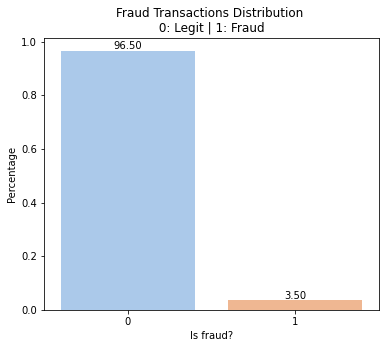

In [ ]:
plt.figure(figsize=(6, 5))
yaxis = train['isFraud'].value_counts().values / train.shape[0]
barplot = sns.barplot(x=[0,1], y=yaxis, palette = 'pastel')
for p in barplot.patches:
    barplot.annotate(format(p.get_height()*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.title("Fraud Transactions Distribution \n 0: Legit | 1: Fraud ")
plt.xlabel('Is fraud?')
plt.ylabel('Percentage')

On remarque que le taux des observations ayant comme étiquette **isFraud =0 est 96.5%**, tandis que celles qui ont l'étiquette **isFraud=1 est 3.53%**. On constate qu'on a un problème de classes non équilibrées. 

### **TransactionDT - timedelta from a given reference datetime**

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)


“La première valeur de TransactionDT  est  86400, elle  correspond au nombre de secondes dans le jour, donc l'unité de temps utilisé est les secondes. Alors la durée dans lauelle on a généré ce jeu de données est  6 mois, vue que la valeur maximale de TransactionDT est  15811131, qui correspond au jour 183."

In [ ]:
train['TransactionDT'].describe()

count    5.905400e+05
mean     7.372311e+06
std      4.617224e+06
min      8.640000e+04
25%      3.027058e+06
50%      7.306528e+06
75%      1.124662e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64

In [ ]:
train_span = (train['TransactionDT'].max() - train['TransactionDT'].min())/(3600*24)
test_span = (test['TransactionDT'].max() - test['TransactionDT'].min())/(3600*24)
total_span = (test['TransactionDT'].max() - train['TransactionDT'].min())/(3600*24)
gap_span = (test['TransactionDT'].min() - train['TransactionDT'].max())/(3600*24)
print('Time span of Train dataset is {:.2f} days'.format(train_span))
print('Time span of Test dataset is {:.2f} days'.format(test_span))
print('Time span of Total dataset is {:.2f} days'.format(total_span))
print('Time gap between train and test is {:.2f} days'.format(gap_span))

Time span of Train dataset is 182.00 days
Time span of Test dataset is 183.00 days
Time span of Total dataset is 395.00 days
Time gap between train and test is 30.00 days


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


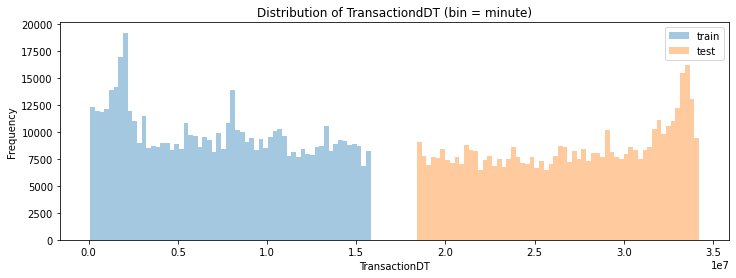

In [ ]:

plt.figure(figsize=(12,4))
sns.distplot(train['TransactionDT'],kde=False,bins=60)
sns.distplot(test['TransactionDT'],kde=False,bins=60)
plt.legend(['train', 'test'])
plt.ylabel('Frequency')
plt.title('Distribution of TransactiondDT (bin = minute)');
plt.show()

 ***Create new feature from TransactionDT***

In [ ]:
train['hour'] = ((train['TransactionDT']//3600)%24)+1
test['hour'] = ((test['TransactionDT']//3600)%24)+1
train

TransactionID  isFraud  ...                     DeviceInfo  hour
0             2987000        0  ...                            NaN     1
1             2987001        0  ...                            NaN     1
2             2987002        0  ...                            NaN     1
3             2987003        0  ...                            NaN     1
4             2987004        0  ...  SAMSUNG SM-G892A Build/NRD90M     1
...               ...      ...  ...                            ...   ...
590535        3577535        0  ...                            NaN    24
590536        3577536        0  ...                            NaN    24
590537        3577537        0  ...                            NaN    24
590538        3577538        0  ...                            NaN    24
590539        3577539        0  ...                            NaN    24

[590540 rows x 435 columns]

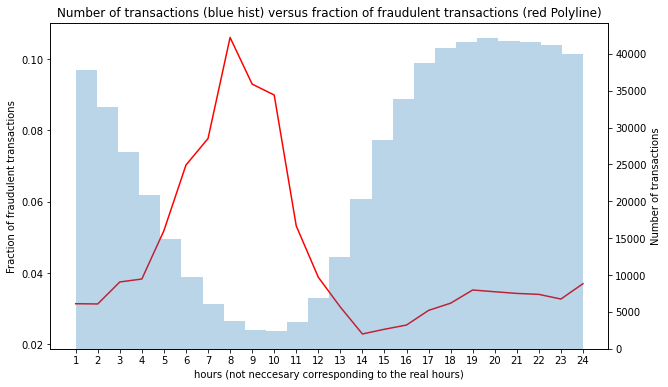

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train.groupby('hour').mean()['isFraud'], color='r')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(train['hour'], alpha=0.3, bins=24)
ax.set_xlabel('hours (not neccesary corresponding to the real hours)')
ax.set_ylabel('Fraction of fraudulent transactions')
ax2.set_ylabel('Number of transactions')
plt.title('Number of transactions (blue hist) versus fraction of fraudulent transactions (red Polyline)')
plt.xticks(np.arange(1, 25, 1))
plt.show()

On remarque que de 5h à 11h la fraction des fraud est plus élevée par rapport aux autres heures.



### **TransactionAmt**



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

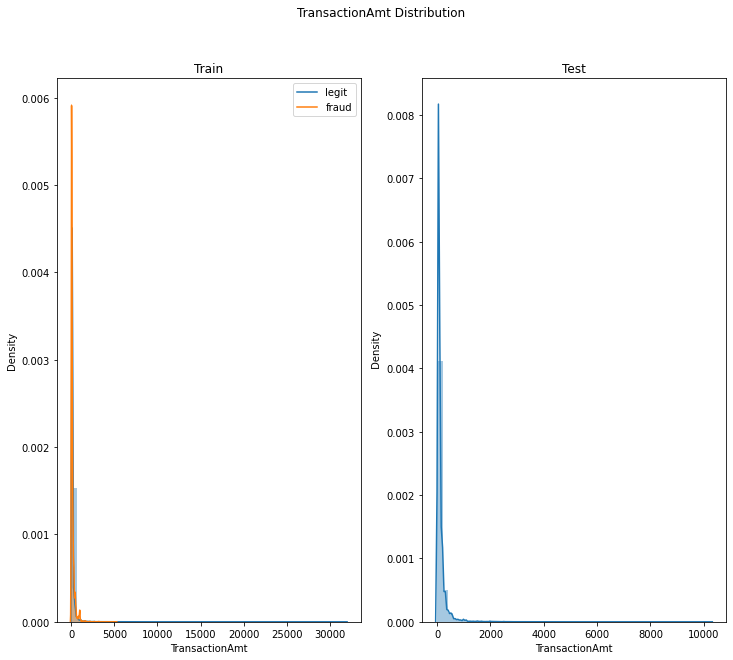

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
sns.distplot(train[train['isFraud']==0]['TransactionAmt'])
sns.distplot(train[train['isFraud']==1]['TransactionAmt'])
plt.ylabel('Density') ##sns adds the density in order to compare the importance of each class (sometimes the continuous values are note 
                                                 # splitted into classes with the same expanse "étendue")
plt.legend(['legit','fraud'])
plt.title('Train')
plt.suptitle('TransactionAmt Distribution' , fontsize=12)
plt.subplot(1,2,2)
sns.distplot(test['TransactionAmt'])
plt.ylabel(' Density')
plt.title('Test')
plt.show()



Plusieurs TansactionAmt  sont presque invisibles en raison du nombre important d'observation. on fait une visualisation pour le log(TransactionAmt) comme ça les valeurs les plus étndues de cette colonne vont se rapprocher,et on obtiendra une meilleure visualisation

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

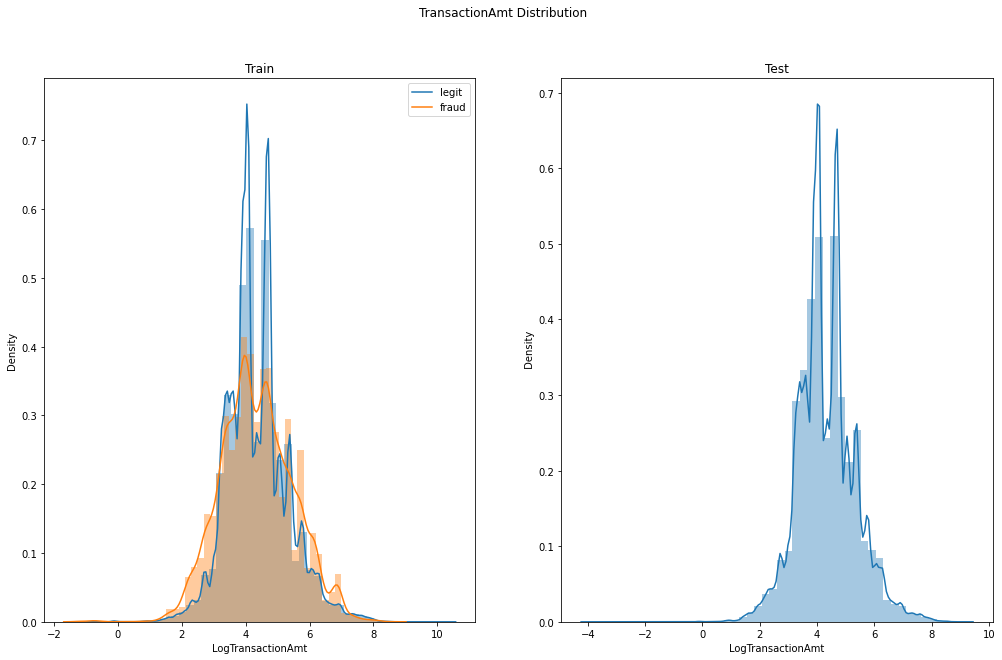

In [ ]:

train['LogTransactionAmt'] = np.log(train['TransactionAmt'])
test['LogTransactionAmt'] = np.log(test['TransactionAmt'])

plt.figure(figsize=(17,10))
plt.subplot(1,2,1)
sns.distplot(train[train['isFraud']==0]['LogTransactionAmt'])
sns.distplot(train[train['isFraud']==1]['LogTransactionAmt'])
plt.ylabel('Density') ##sns adds the density in order to compare the importance of each class (sometimes the continuous values are note 
                                                 # splitted into classes with the same expanse "étendue")
plt.legend(['legit','fraud'])
plt.title('Train')
plt.suptitle('TransactionAmt Distribution' , fontsize=12)
plt.subplot(1,2,2)
sns.distplot(test['LogTransactionAmt'])
plt.ylabel(' Density')
plt.title('Test')
plt.show()



les LogTransactionAmt > 5.5 (244 dollars) et celles inférieures à  3.3 (27 dollars) ont une plus grande density et une plus grande fréquence et elles sont frauduleuses.  Les  LogTransactionAmt dans l'intervalle [3.3 ; 5.5] ont plus de chance d'être des transactions légitimes 

### **ProductCD**

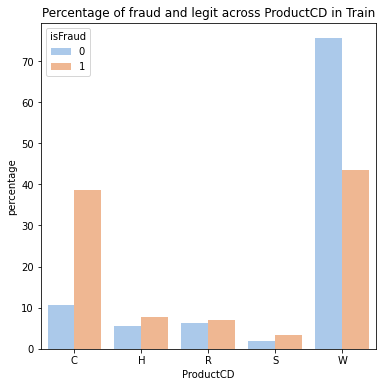

In [ ]:
plt.figure(figsize=(6,6))
train_ProductCD = (train.groupby(['isFraud'])['ProductCD'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('ProductCD'))
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=train_ProductCD,palette = 'pastel')
plt.title('Percentage of fraud and legit across ProductCD in Train')
plt.show()

on remarque  que si la transaction est frauduleuse, il y a 40% de chances qu'il s'agisse du produit C. Étant donné que seulement 10% des transactions légitimes sont C, on  **peut** dire qu'il y a plus de chances que ce soit une fraude si le produit est C.

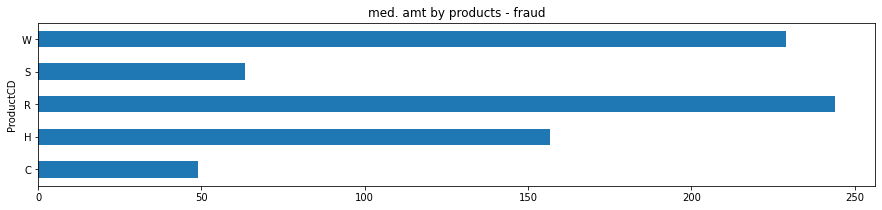

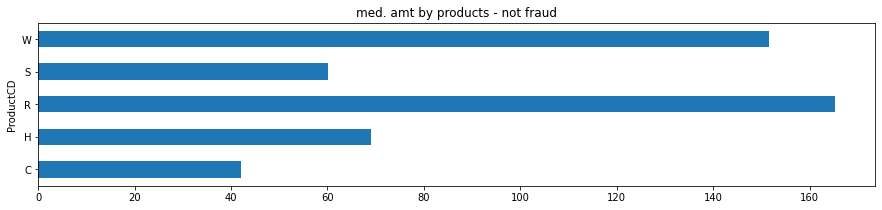

In [ ]:
train.loc[train['isFraud']==1]\
.groupby('ProductCD')['TransactionAmt'].mean().sort_index().plot(kind='barh',
                                                                 figsize=(15,3),
                                                                 title='med. amt by products - fraud')
plt.show()

train.loc[train['isFraud']==0]\
.groupby('ProductCD')['TransactionAmt'].mean().sort_index().plot(kind='barh',
                                                                 figsize=(15,3),
                                                                 title='med. amt by products - not fraud')
plt.show()

On remarque que il n'y pas une relation entre le montant moyen d'un produit et la nature de la transaction. on voit le même montant moyen et dans la classe frauduleuse et dans la classe des transactions légitimes 

### **Card1 - Card6**


* card1,card2, card3, card5 : numériques
* card4, car6 :catégorielles



**Card 1**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

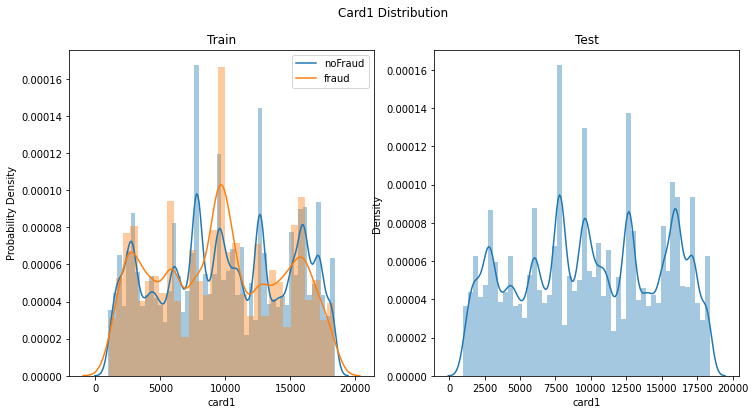

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(train[train['isFraud']==0]['card1'])
sns.distplot(train[train['isFraud']==1]['card1'])
plt.ylabel('Probability Density')
plt.legend(['noFraud','fraud'])
plt.suptitle('Card1 Distribution' , fontsize=12)
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test['card1'])
plt.title('Test')
plt.show()

Comme on peut le voir, la colonne card1 est donnée comme catégorielle mais elle se comporte comme des données continues. elle a '13553' valeurs uniques, Il s'agit peut étre d'une variable catégorielle codée. L'ensemble de données contient de nombreuses variables à cardinalité élevée, et il est difficile de modéliser une telle variable.

**card2**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

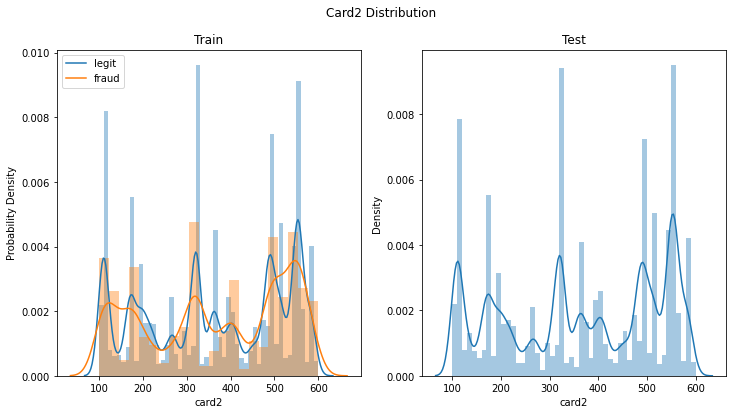

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['card2'].isnull())]['card2'])
sns.distplot(train[(train['isFraud']==1) & (~train['card2'].isnull())]['card2'])
plt.ylabel('Probability Density')
plt.legend(['legit','fraud'])
plt.title('Train')
plt.suptitle('Card2 Distribution' , fontsize=12)
plt.subplot(1,2,2)
sns.distplot(test[~test['card2'].isnull()]['card2'])
plt.title('Test')
plt.show()

 **Card3**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

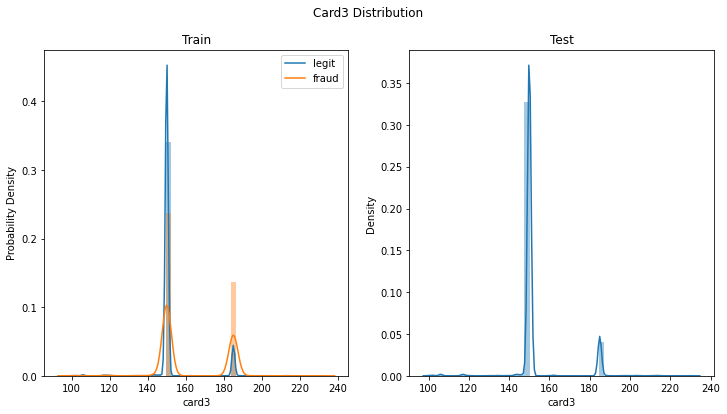

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['card3'].isnull())]['card3'])
sns.distplot(train[(train['isFraud']==1) & (~train['card3'].isnull())]['card3'])
plt.ylabel('Probability Density')
plt.legend(['legit','fraud'])
plt.title('Train')
plt.suptitle('Card3 Distribution', fontsize=12)
plt.subplot(1,2,2)
sns.distplot(test[~test['card3'].isnull()]['card3'])
plt.title('Test')
plt.show()

les valeurs autour de 150 ont plus de chances d'être légitimes, nous pouvons créer une nouvelle feature qui catégorise card3
* If the value is larger than 160, then 'Positive‘
* Otherwise 'Negative'

In [ ]:
def new_card3(row):
    if row==np.nan:
        return row
    else:
        if row > 160 :
            return 'Positive'
        else:
            return 'Negative'
        
train['card3'] = train['card3'].apply(new_card3)
test['card3'] = test['card3'].apply(new_card3)


In [ ]:
train.card3
test.card3

0         Negative
1         Negative
2         Negative
3         Negative
4         Negative
            ...   
506686    Positive
506687    Positive
506688    Negative
506689    Negative
506690    Negative
Name: card3, Length: 506691, dtype: object

**card4** *Credit card company*

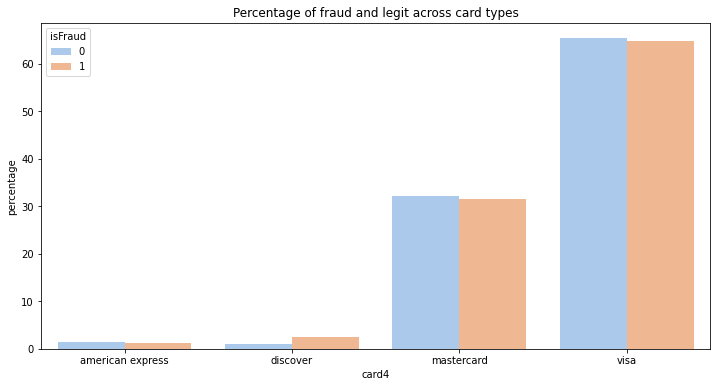

In [ ]:
plt.figure(figsize=(12,6))
train_card4 = (train[~train['card4'].isnull()].groupby(['isFraud'])['card4'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card4'))
sns.barplot(x="card4", y="percentage", hue="isFraud", data=train_card4, palette = 'pastel')
plt.title('Percentage of fraud and legit across card types')
plt.show()

La plupart des transactions sont effectuées par les cartes de type Visa et Mastercard. mais on  ne peut tirer d'information sur le type de carte le plus utilisé pour des transactions frauduleuses vu qu'ils ont un méme pourcentage  est utilisé pour les transactions fraud et les transactions nonFraud

**card5**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


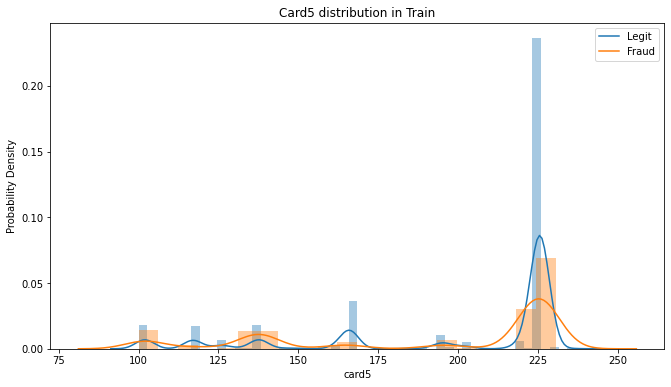

In [ ]:
plt.figure(figsize=(11,6))
sns.distplot(train[(train['isFraud']==0) & (~train['card5'].isnull())]['card5'])
sns.distplot(train[(train['isFraud']==1) & (~train['card5'].isnull())]['card5'])
plt.legend(['Legit','Fraud'])
plt.ylabel('Probability Density')
plt.title('Card5 distribution in Train')
plt.show()

**card6** *Type of card*

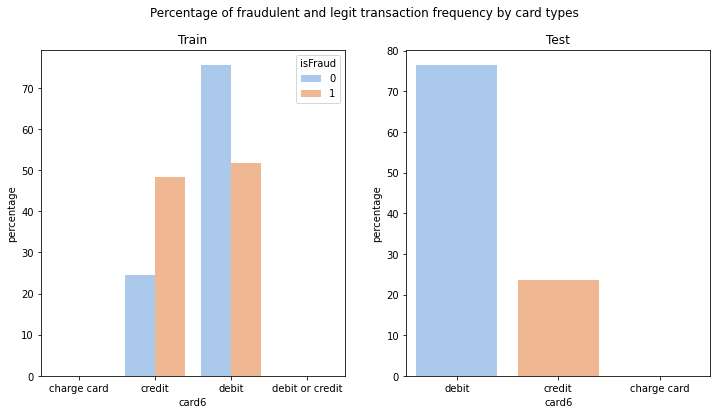

In [ ]:
# Rerun this before replacement
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
train_card6 = (train[~train['card6'].isnull()].groupby(['isFraud'])['card6'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card6'))
sns.barplot(x="card6", y="percentage", hue="isFraud", data=train_card6, palette = 'pastel')
plt.title('Train')
plt.subplot(1,2,2)
test_card6 =test[~test['card6'].isnull()]['card6'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(x="index", y="percentage", data=test_card6, palette = 'pastel')
plt.xlabel('card6')
plt.title('Test')
plt.suptitle('Percentage of fraudulent and legit transaction frequency by card types', fontsize=12)
plt.show()

In [ ]:
print('%d observations are charge card' % train[train['card6']=='charge card'].shape[0])
print('%d observations are debit or credit card' % train[train['card6']=='debit or credit'].shape[0])

15 observations are charge card
30 observations are debit or credit card


Dans feature card6 il ya seulement 15 observations correspondantes à "charge card" et 30 observations correspondantes à "debit or credit" dans l'ensemble d'entrainement mais il n'y a pas de "debit or credit" dans l'ensemble de test

Comme la taille de l'échantillon n'est pas suffisante pour trouver un modèle général et que le type majoritaire de card6 est 'débit', nous pouvons remplacer ces observations par le type  'débit'

In [ ]:
def replacetodebit(row):
    if row==np.nan:
        return row
    if row=='debit or credit' or row=='charge card':
        return 'debit'
    else:
        return row
    
train['card6'] = train['card6'].apply(replacetodebit)
test['card6'] = test['card6'].apply(replacetodebit)

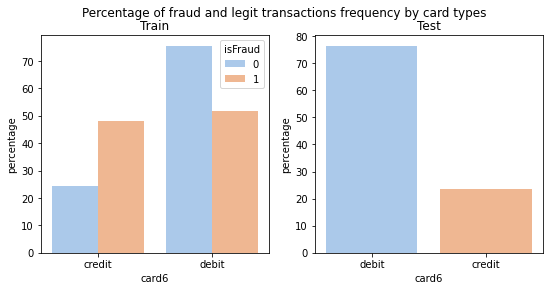

In [ ]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
train_card6 = (train[~train['card6'].isnull()].groupby(['isFraud'])['card6'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card6'))
sns.barplot(x="card6", y="percentage", hue="isFraud", data=train_card6, palette = 'pastel')
plt.title('Train')
plt.subplot(1,2,2)
test_card6 =test[~test['card6'].isnull()]['card6'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(x="index", y="percentage", data=test_card6, palette = 'pastel')
plt.xlabel('card6')
plt.title('Test')
plt.suptitle('Percentage of fraud and legit transactions frequency by card types', fontsize=12)
plt.show()

### **Addr1- Addr2**

In [ ]:
print('There are %d regions in addr1 of Train' % len(train['addr1'].value_counts()))
print('There are %d regions in addr1 of Test' % len(test['addr1'].value_counts()))

print('There are %d billing countries in addr2 of Train' % len(train['addr2'].value_counts()))
print('There are %d billing countries in addr2 of Test' % len(test['addr2'].value_counts()))

There are 332 regions in addr1 of Train
There are 292 regions in addr1 of Test
There are 74 billing countries in addr2 of Train
There are 72 billing countries in addr2 of Test


### **dist1**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


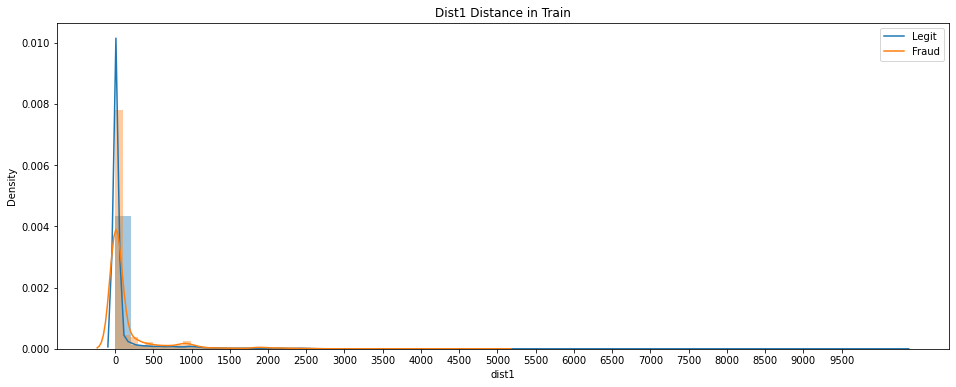

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(train[(train['isFraud']==0) & (~train['dist1'].isnull())]['dist1'])
sns.distplot(train[(train['isFraud']==1) & (~train['dist1'].isnull())]['dist1'])
plt.legend(['Legit','Fraud'])
plt.xticks(np.arange(0, 10000, 500))
plt.title('Dist1 Distance in Train')
plt.show()

on remarque que les transactions Frauduleuse ont une dist1 moyenne plus élevée que les transactions légitimed. 
On peut conclure que les fraudeurs commettent généralement des fraudes à une distance relativement plus longue de l'adresse du titulaire de la carte.

### **dist2**

In [ ]:
print( (train["dist2"].isnull().sum().sum() / train.shape[0])*100 )


93.62837403054831


On remarque que le taux de données manquantes est très élevé dans cette colonne.

**Conclusion**: cette colonne n'apporte pas des infromation, elle va être supprimé dans la phase de traitement des DM.

### **P_emaildomain R_emaildomain**

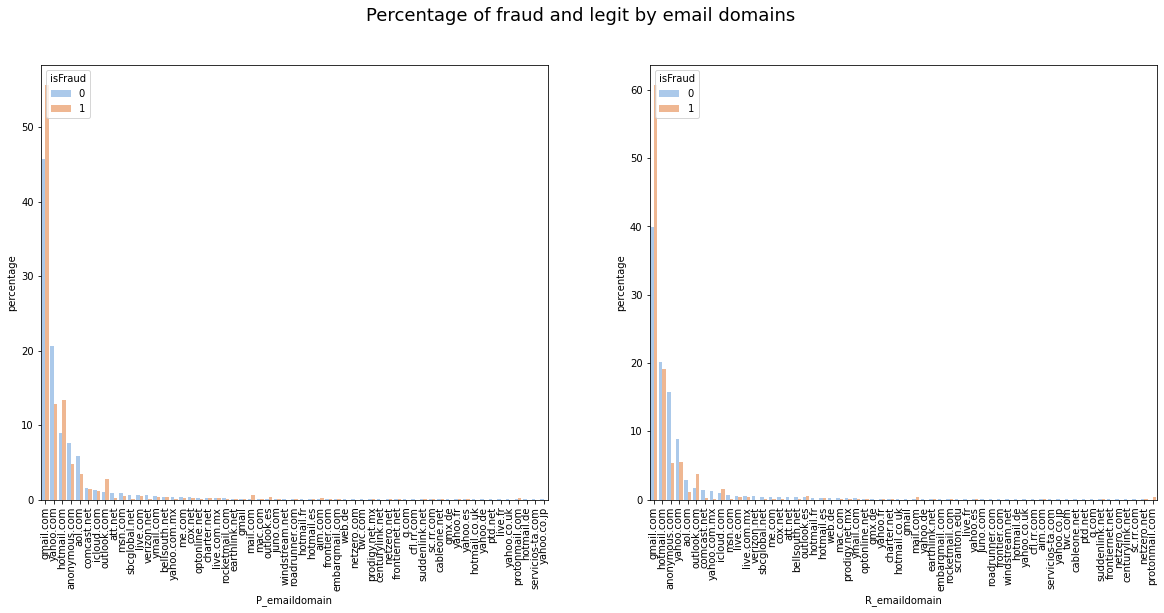

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
train_P_email = (train[~train['P_emaildomain'].isnull()].groupby(['isFraud'])['P_emaildomain'].value_counts(normalize=True).rename('percentage').mul(100).reset_index())
sns.barplot(x="P_emaildomain", y="percentage", hue="isFraud", data=train_P_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
train_R_email = train[~train['R_emaildomain'].isnull()].groupby(['isFraud'])['R_emaildomain'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(x="R_emaildomain", y="percentage", hue="isFraud", data=train_R_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.suptitle('Percentage of fraud and legit by email domains', fontsize=18)
plt.show()

on regroupe les email domain par les entreprises, et celle qui ont moins de 500 observation comme others.
remplacer les Nan par NoInfo car aucune autre colonne ne nous permet de prédire les DM


In [ ]:
train.loc[train['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'
train.loc[train['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo'
train.loc[train['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train.loc[train.P_emaildomain.isin(train.P_emaildomain.value_counts()[train.P_emaildomain.value_counts() <= 500 ].index), 'P_emaildomain'] = "Others"
train.P_emaildomain.fillna("NoInf", inplace=True)

train.loc[train['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

train.loc[train['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo'
train.loc[train['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
train.loc[train.R_emaildomain.isin(train.R_emaildomain.value_counts()[train.R_emaildomain.value_counts() <= 300 ].index), 'R_emaildomain'] = "Others"
train.R_emaildomain.fillna("NoInf", inplace=True)

In [ ]:
test.loc[test['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'
test.loc[test['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo'
test.loc[test['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
test.loc[test.P_emaildomain.isin(test.P_emaildomain.value_counts()[test.P_emaildomain.value_counts() <= 500 ].index), 'P_emaildomain'] = "Others"
test.P_emaildomain.fillna("NoInf", inplace=True)

test.loc[test['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

test.loc[test['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo'
test.loc[test['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
test.loc[test.R_emaildomain.isin(test.R_emaildomain.value_counts()[test.R_emaildomain.value_counts() <= 300 ].index), 'R_emaildomain'] = "Others"
test.R_emaildomain.fillna("NoInf", inplace=True)

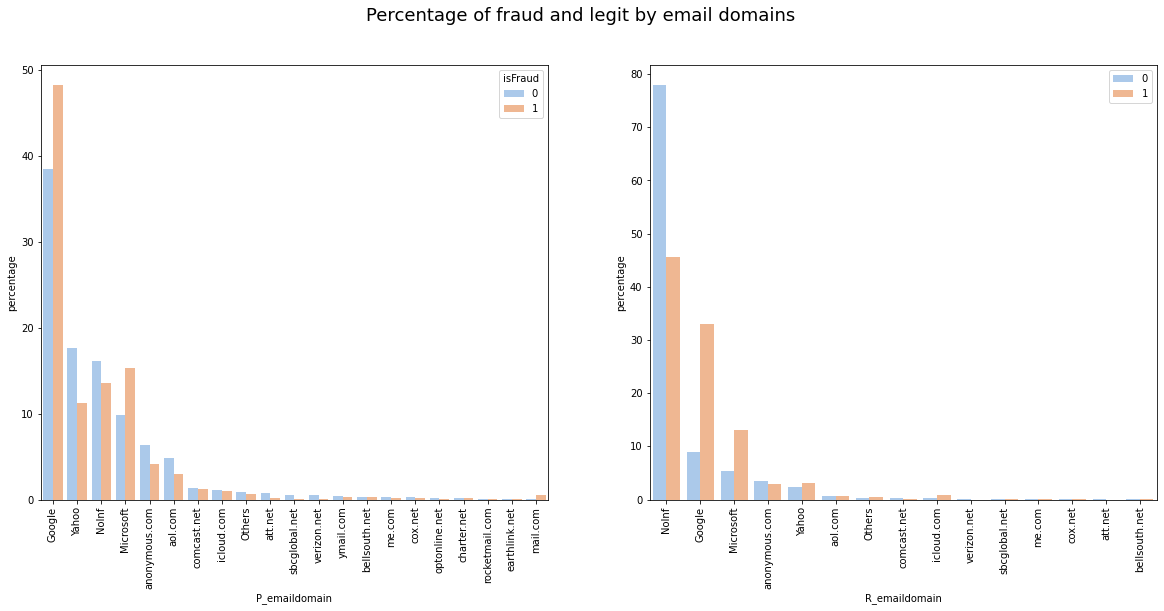

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
train_P_email = (train[~train['P_emaildomain'].isnull()].groupby(['isFraud'])['P_emaildomain'].value_counts(normalize=True).rename('percentage').mul(100).reset_index())
sns.barplot(x="P_emaildomain", y="percentage", hue="isFraud", data=train_P_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
train_R_email = train[~train['R_emaildomain'].isnull()].groupby(['isFraud'])['R_emaildomain'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(x="R_emaildomain", y="percentage", hue="isFraud", data=train_R_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.suptitle('Percentage of fraud and legit by email domains', fontsize=18)
plt.show()

### **C1 - C14** 
comptage, comme le nombre d'adresses associées à la carte de paiement, etc. La signification réelle est masquée.

In [ ]:
import warnings
plt.figure(figsize=(20,50))
var = ['C' + str(i) for i in range(1,15)]
i = 1
for col in var:
    plt.subplot(7,4,i)
    sns.scatterplot(x="TransactionDT", y=col,hue="isFraud",data=train[~train[col].isnull()])
    plt.title('Train '+ col)
    i += 1
    plt.subplot(7,4,i)
    sns.scatterplot(x="TransactionDT",y=col,data=test[~test[col].isnull()])
    plt.title('Test '+ col)
    i += 1
plt.show()



On remarque que C5 et C9 n'ont pas de données abérantes contrairement aux autres .

Toutes les colonnes C sont du type de données numériques et le résumé est comme ci-dessous


In [ ]:
print(train[var].isnull().sum().sum())
print(test[var].isnull().sum().sum())

4787

On remarque que les colonnes ' C' n'ont pas des DM   dans l'ensemble des train contrairement dans l'ensemble des test



### **D1-D15**  imedelta, comme les jour entre la transactions  etc.

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


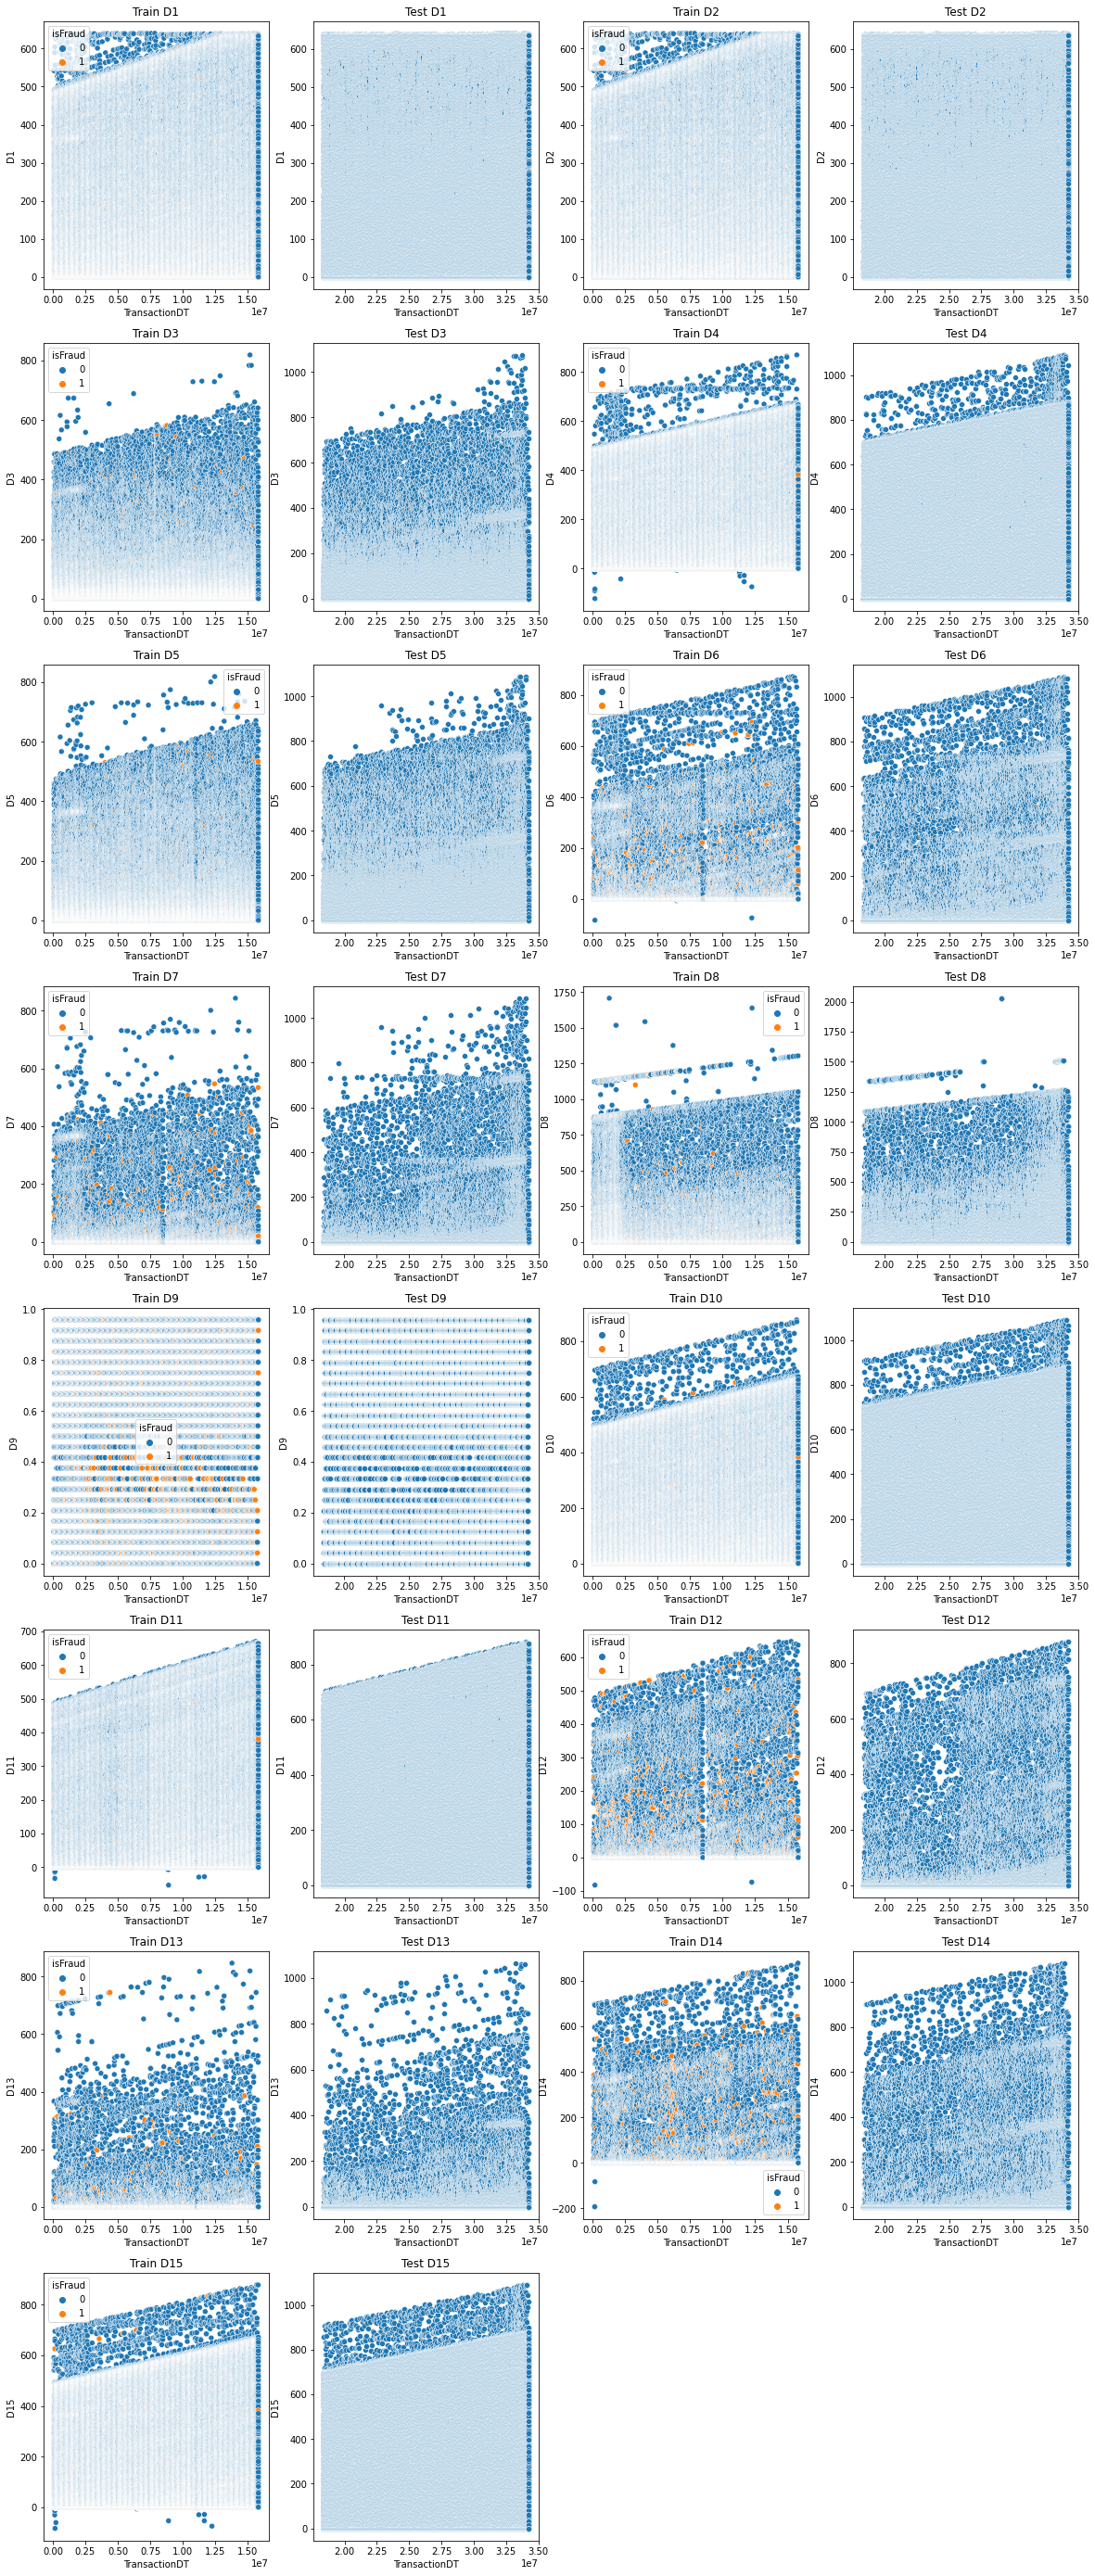

In [ ]:
plt.figure(figsize=(20,50))
var = ['D' + str(i) for i in range(1,16)]
i = 1
for col in var:
    plt.subplot(8,4,i)
    sns.scatterplot(x="TransactionDT",y=col,hue="isFraud",data=train[~train[col].isnull()])
    plt.title('Train '+col)
    i += 1
    plt.subplot(8,4,i)
    sns.scatterplot(x="TransactionDT",y=col,data=test[~test[col].isnull()])
    plt.title('Test '+col)
    i += 1
plt.show()

La plupart des fonctionnalités D augmentent de manière monotone avec TransactionDT, ce qui est logique car elles sont présentées par Vesta comme timedelta, telles que les jours entre la transaction précédente, etc.

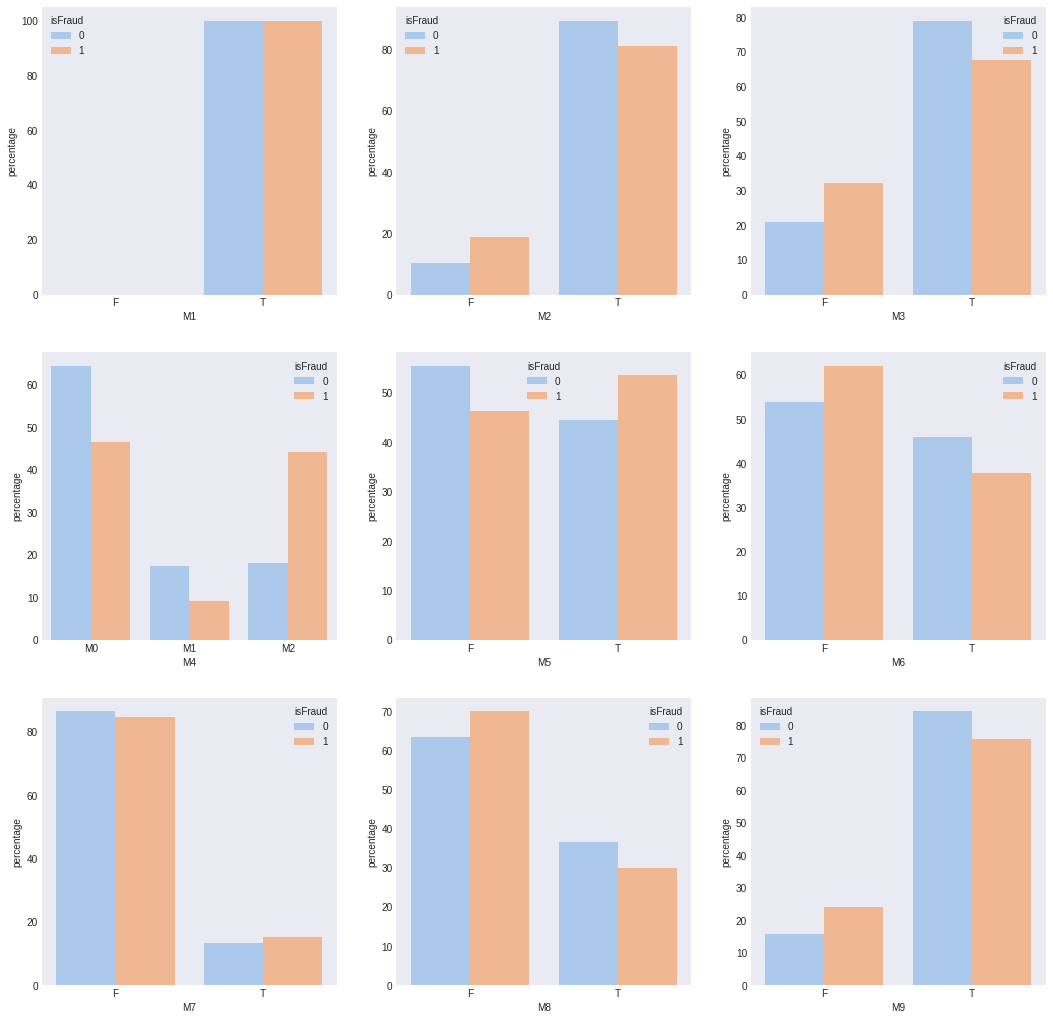

In [ ]:
plt.figure(figsize=(18,18))
var = ['train_m' + str(i) for i in range(1,10)]
col = ['M' + str(i) for i in range(1,10)]
for i,j,k in zip(var,col,range(1,10)):
    i = (train.groupby(['isFraud'])[j]
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index()
                         .sort_values(j))
    plt.subplot(3,3,k)
    sns.barplot(x=j, y="percentage", hue="isFraud", data=i, palette = 'pastel')
plt.show()

pour chaque colonne on remaque que le taux des observations frauduleuses est le même que les observatin non frauduleuse pour les deux valeurs (T, F, ...etc)

### ***V features***:
 Vesta engineered rich features, including ranking, counting, and other entity relations.


In [ ]:
v_cols = [c for c in train if c[0] == 'V']
train[v_cols].head()

V1   V2   V3   V4   V5   V6   V7  ...  V333  V334  V335  V336  V337  V338  V339
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0

[5 rows x 339 columns]

Beaucoup de 1,0 et NAN, mais seulement quelques valeurs plus grandes

In [ ]:
train[v_cols].describe()

V1             V2  ...           V338           V339
count  311253.000000  311253.000000  ...   82351.000000   82351.000000
mean        0.999945       1.045204  ...     151.160542     100.700882
std         0.007390       0.240133  ...    1095.034387     814.946722
min         0.000000       0.000000  ...       0.000000       0.000000
25%         1.000000       1.000000  ...       0.000000       0.000000
50%         1.000000       1.000000  ...       0.000000       0.000000
75%         1.000000       1.000000  ...       0.000000       0.000000
max         1.000000       8.000000  ...  104060.000000  104060.000000

[8 rows x 339 columns]

on prend les moyenne de chaque V feature pour dessiner le graphe

In [ ]:
train['v_mean'] = train[v_cols].mean(axis=1)

 une transformation logarithmique pour mieux montrer

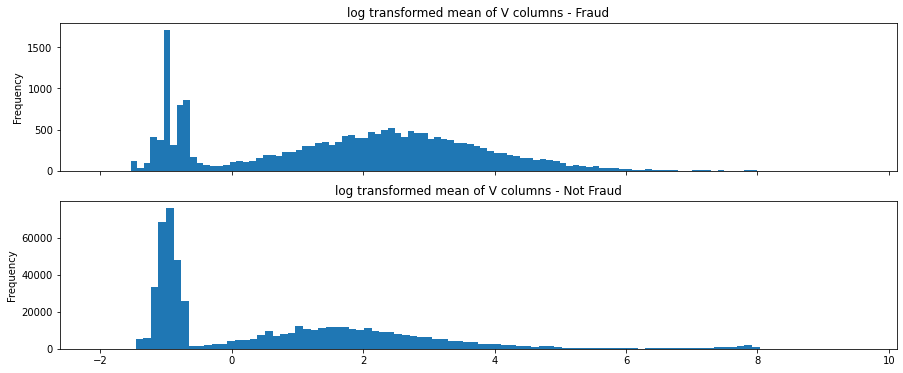

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train.loc[train['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train.loc[train['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          ax=ax2)
plt.show()

c'est difficile de tirer des informations vu que ya pas vraiment de différences entre Les transactions frauduleuses par rapport à Vxx et les transactions non frauduleuses par rapport à Vxx

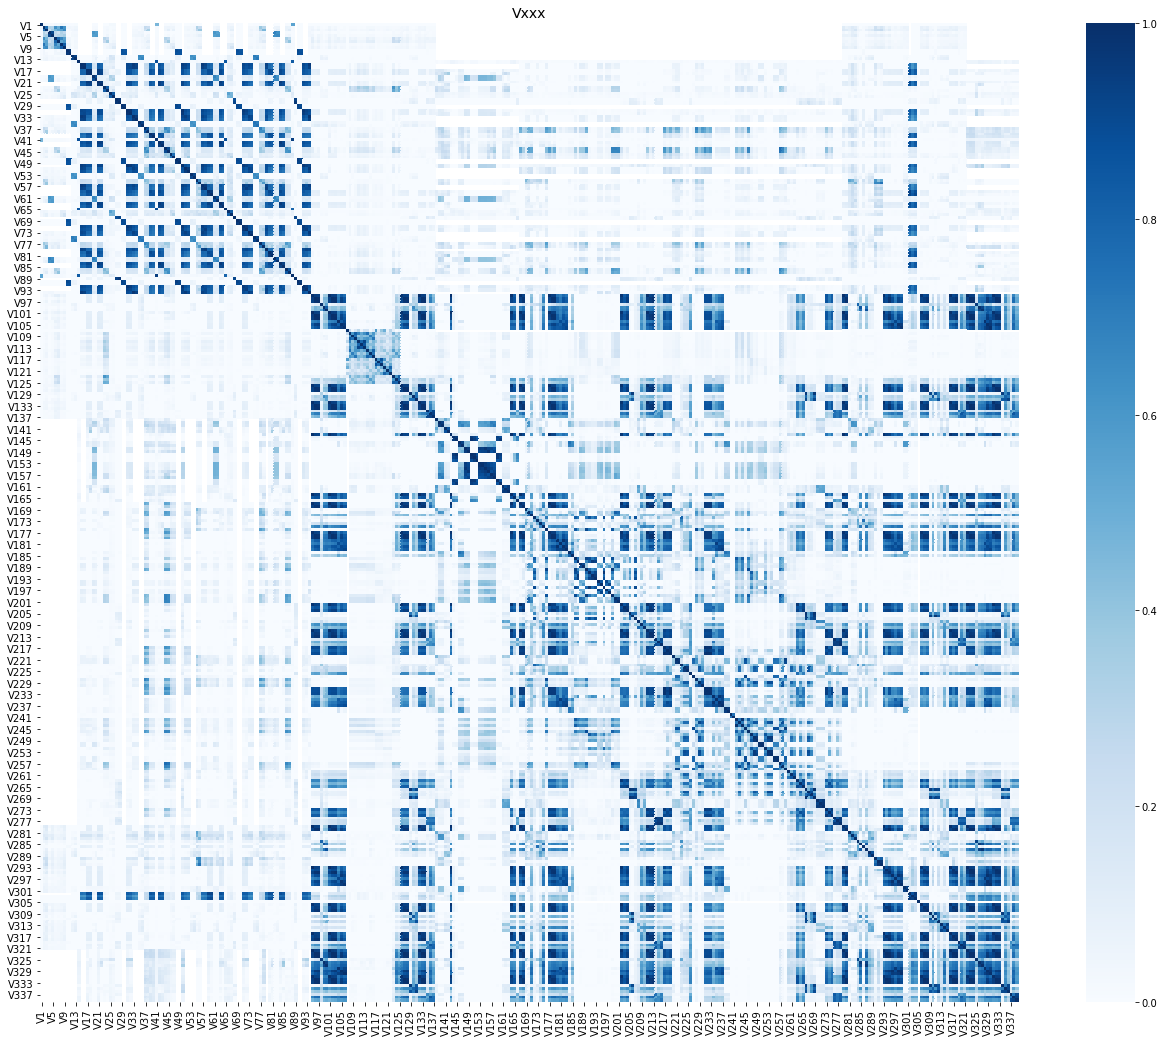

In [ ]:
v_cols = ['V{}'.format(i) for i in range(1, 340, 1)]
corr_table = train[v_cols].corr()

fig = plt.figure(figsize=(24, 18), facecolor='w')
sns.heatmap(corr_table, vmin=0, vmax=1, center=0.5, square=True, cmap='Blues')
plt.title('Vxxx',fontsize=14)
plt.show()

On remarque que la plupart des colonnes V semblent redondantes et corrélées, Pour cela On a idée d'effectuer la PCA sur les fonctionnalités V qui peuvent non seulement réduire la dimensionnalité, mais également économiser le temps d'exécution, ainsi que décorréler les fonctionnalités pour améliorer les performances du modèle.L'inconvénient de PCA est que nous perdrons l'interprétation des fonctionnalités,Mais ce n'est pas un gros problème puisque la signification de ces fonctionnalités V est de toute façon inconnue.

### **ID**

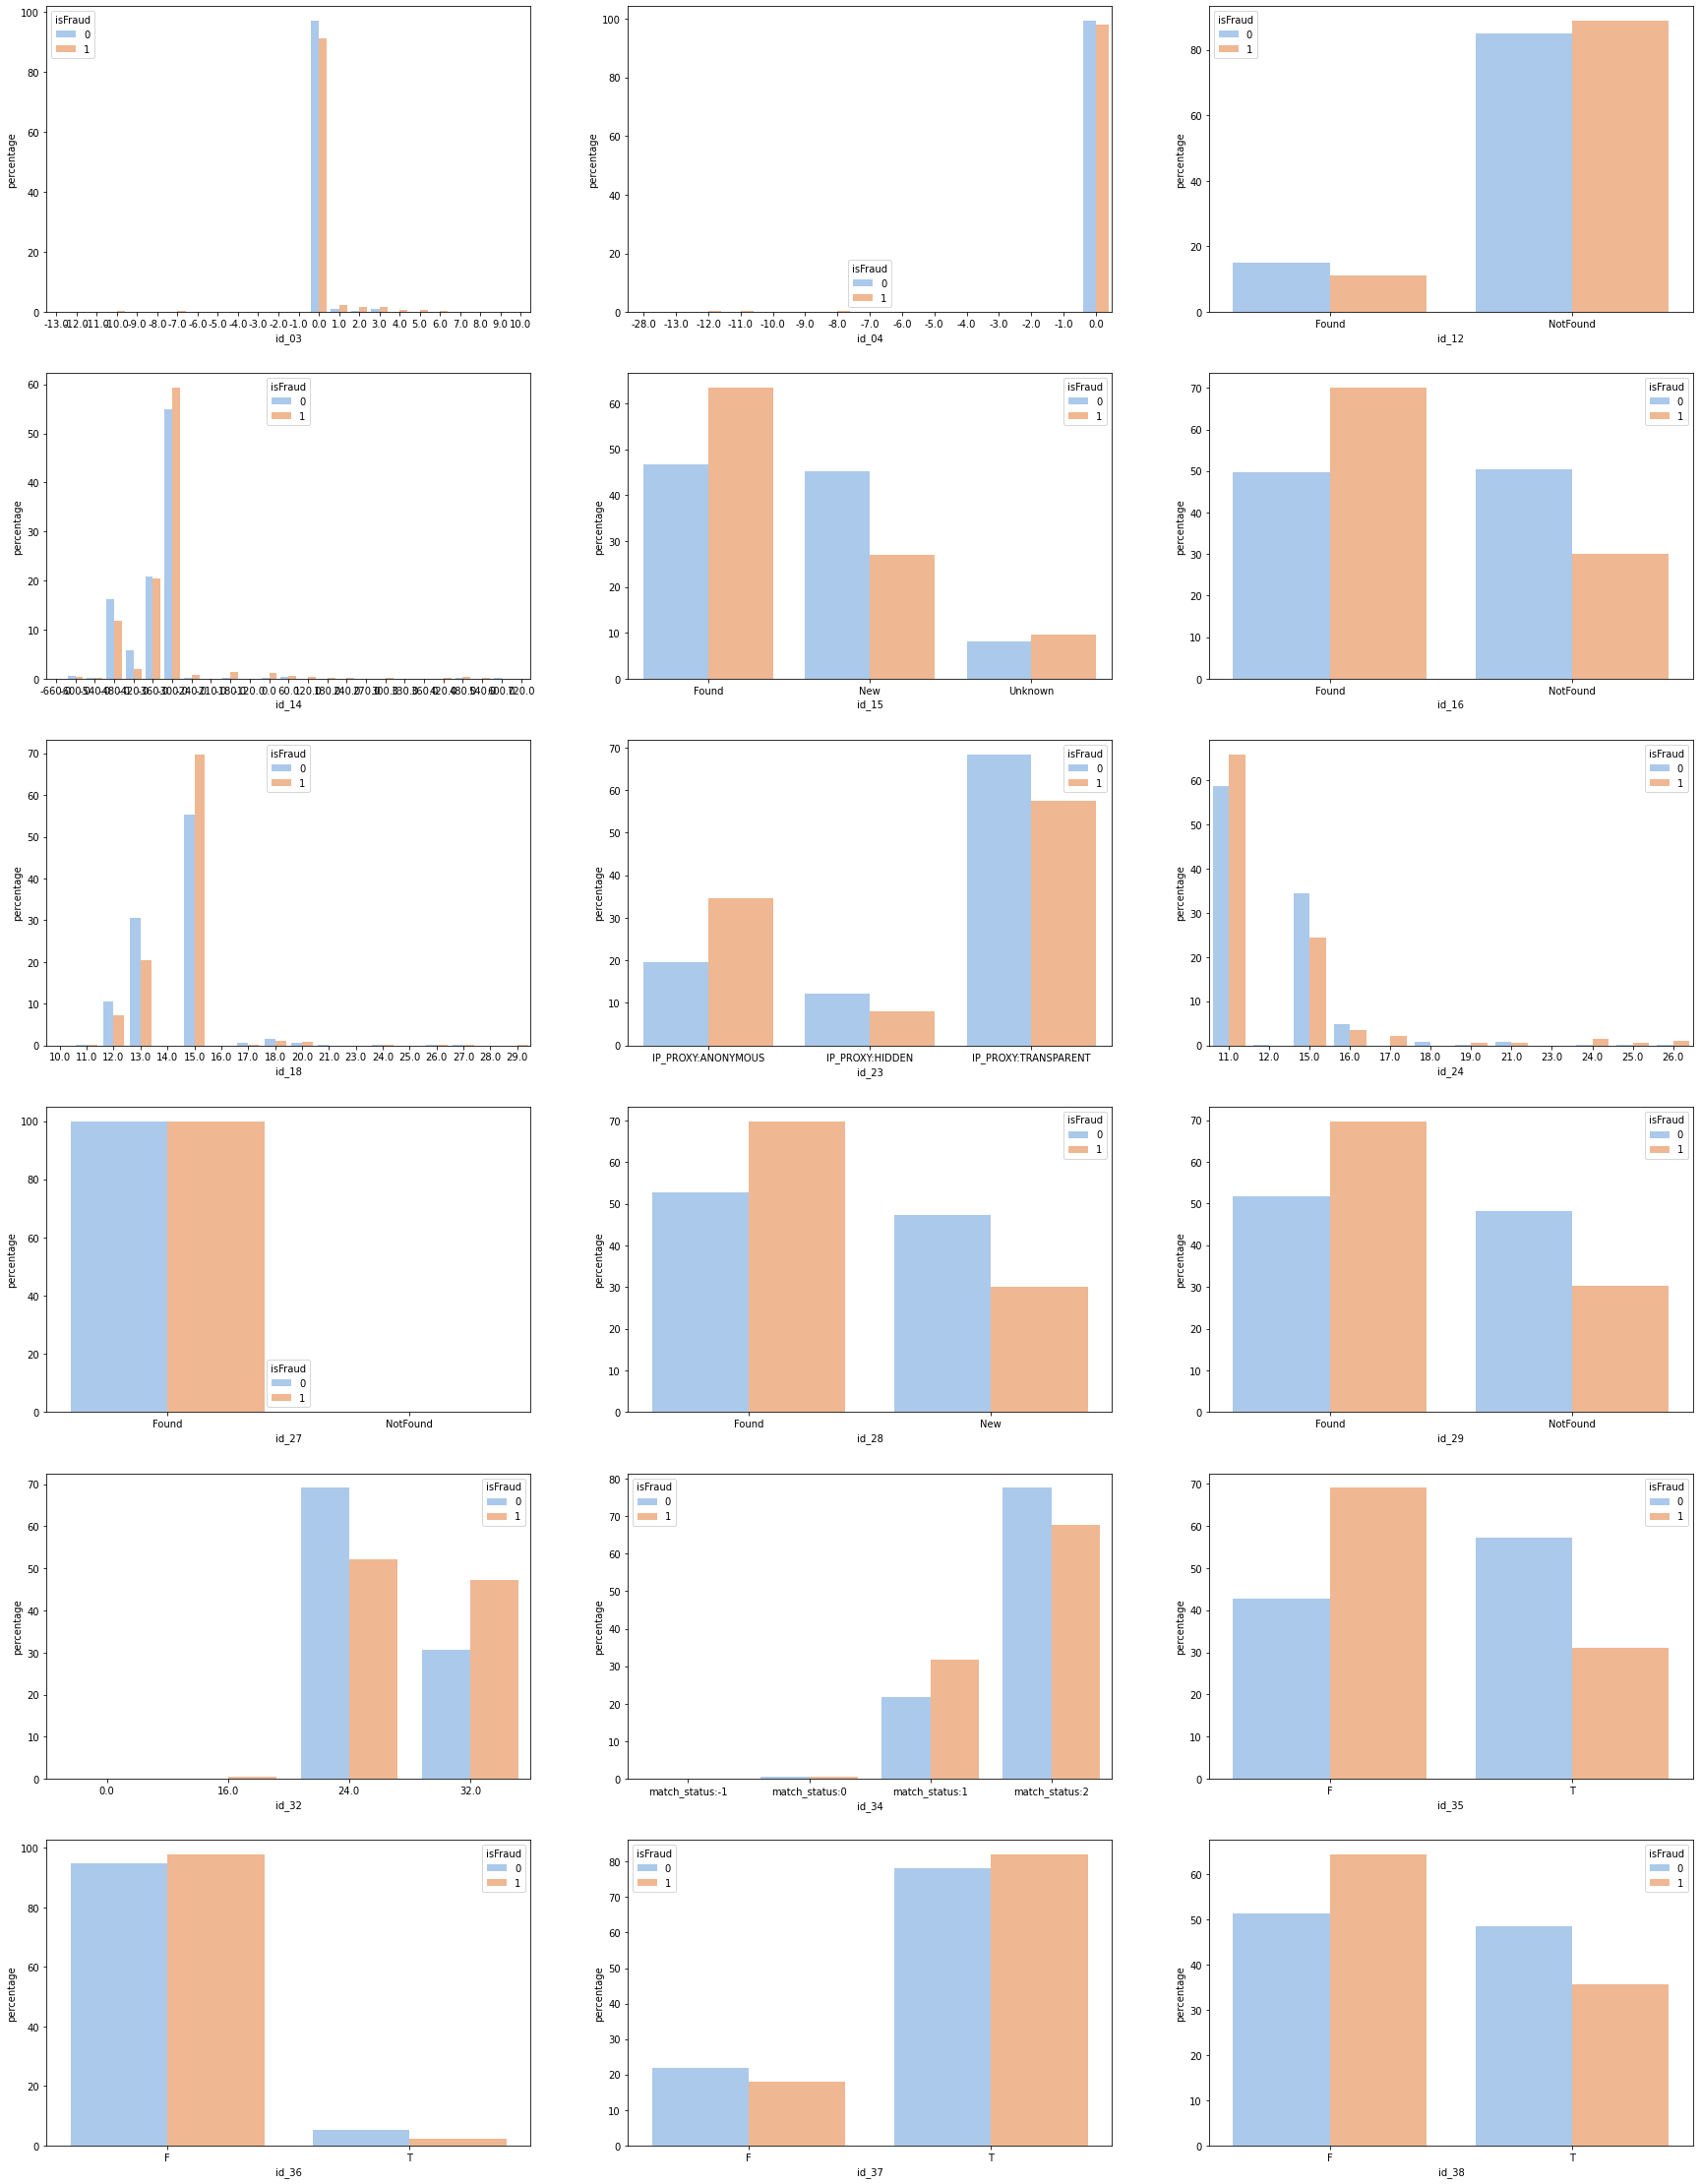

In [ ]:
plt.figure(figsize=(30,40))
var = ['train_id_' + str(i) for i in range(1,19)]
col = ['id_'+str(i) for i in ['03','04',12,14,15,16,18,23,24,27,28,29,32,34,35,36,37,38]]
for i,j,k in zip(var,col,range(1,19)):
    i = (train.groupby(['isFraud'])[j]
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index()
                         .sort_values(j))
    plt.subplot(6,3,k)
    sns.barplot(x=j, y="percentage", hue="isFraud", data=i, palette = 'pastel')
plt.show()

### **DeviceType and DeviceInfo**

In [ ]:
train[~train.iloc[:, 431:433].isnull().any(axis=1)].iloc[:, 431:433].head()

DeviceType                     DeviceInfo
4      mobile  SAMSUNG SM-G892A Build/NRD90M
8      mobile                     iOS Device
10    desktop                        Windows
16    desktop                          MacOS
17    desktop                        Windows

In [ ]:
print(len(train['DeviceType'].value_counts()))
print(len(train['DeviceInfo'].value_counts()))

2
1782


In [ ]:
print(len(test['DeviceType'].value_counts()))
print(len(test['DeviceInfo'].value_counts()))

2
2226


Le nombre de valeur dans la colonne DeviceType est 2 dans le train et le test. Mais On trouve beaucoup de valeurs dans la  colonne 'DeviceInfo' surtout dans l'ensemble de test. 

In [ ]:
train.drop(columns={"TransactionDT"},inplace=True)
test.drop(columns={"TransactionDT"},inplace=True)


## **Prétraiement**

### **Identic Columns**

In [ ]:
def get_rate_IV(df_train_complete):
  nbr=df_train_complete.shape[0]
  df_col_elim =pd.DataFrame()
  for i in range(df_train_complete.shape[1]):
    max_rate_IV= ((df_train_complete.iloc[:,i].value_counts()).max())/nbr
    df_col_elim=df_col_elim.append({"Column":df_train_complete.columns[i],"Rate_M_IV":max_rate_IV},ignore_index=True)##
  return df_col_elim

def eliminate_rate_IV(df_train_complete,df_test_complete):
  df_col_elim = get_rate_IV(df_train_complete)
  #print(df_col_elim[df_col_elim["Rate_M_IV" ]> 0.99])
  df_col_elim2= get_rate_IV(df_test_complete)
  #print(df_col_elim2[df_col_elim2["Rate_M_IV" ]> 0.99])
  int_df = pd.merge(df_col_elim[df_col_elim["Rate_M_IV" ]> 0.99], df_col_elim2[df_col_elim2["Rate_M_IV" ]> 0.99], how ='inner', on =["Column"]) 
  print(int_df)
  df_train_complete.drop(int_df.Column, axis=1, inplace=True)
  df_test_complete.drop(int_df.Column, axis=1, inplace=True)

eliminate_rate_IV(train,test)


   Column  Rate_M_IV_x  Rate_M_IV_y
0    V107     0.999048     1.000000
1    V108     0.994415     0.993643
2    V111     0.996544     0.996438
3    V112     0.994400     0.992824
4    V113     0.995983     0.995451
5    V117     0.998237     0.999045
6    V118     0.997795     0.997697
7    V119     0.998154     0.998540
8    V120     0.997761     0.998234
9    V121     0.995011     0.993714
10   V122     0.997131     0.997085
11   V305     0.999973     0.999992


### **Missing Values**

In [ ]:
def detectmissing(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes']) # (the data, the name of column, the index set them by his own)
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']] #we ignore the column "index"
    summary['Missing(%)'] = (df.isnull().sum().values / df.shape[0])*100  
    #summary['Uniques'] = df.nunique().values
    return summary

In [ ]:
summary_train=detectmissing(train)

In [ ]:
summary_test = detectmissing(test)

 **Delete the columns with rate of missing values >=80**

In [ ]:
def delete_col_80(df_train_complete,df_test_complete,summary_train):
  col_80= summary_train[summary_train["Missing(%)"]>= 80]["Name"].tolist()
  df_train_complete.drop(col_80, axis=1, inplace=True)
  df_test_complete.drop(col_80, axis=1, inplace=True)


delete_col_80(train,test,summary_train)

 **Impute Missing values**

In [ ]:
def imputeDM (train, test):
  Y = train.isFraud  
  train.drop(columns = ['isFraud'],inplace=True) 
  cat_cols = train.select_dtypes(include = 'object').columns 
  for i in cat_cols:
    train[i] = train[i].fillna(train[i].mode()[0])
    test[i] = test[i].fillna(train[i].mode()[0])

  num_cols = train.select_dtypes(include=np.number).columns 
  for i in num_cols:
    train[i] = train[i].fillna(train[i].median())
    test[i] = test[i].fillna(train[i].median())

  train['isFraud'] = Y
  return (train, test)

train, test = imputeDM (train, test)
       

### **Outliers**

In [ ]:
print(train[train["isFraud"]==1 ].shape)

(20663, 348)


In [ ]:
train.drop(train[train.dist1>6000].index, axis=0, inplace=True)
train.drop(train[train.TransactionAmt>10000].index, axis=0, inplace=True)
train.loc[train.C1 > 3000, "C1" ] = train.loc[train.C1 <= 3000, "C1" ].mean()
train.loc[train.C2 > 3000, "C2" ] = train.loc[train.C2 <= 3000, "C2" ].mean()
train.loc[train.C4 > 1400, "C4" ] = train.loc[train.C4 <= 1400, "C4" ].mean()
train.loc[train.C6 > 1600, "C6" ] = train.loc[train.C6 <= 1600, "C6" ].mean()
train.loc[train.C7 > 1400, "C7" ] = train.loc[train.C7 <= 1400, "C7" ].mean()
train.loc[train.C8 > 1000, "C8" ] = train.loc[train.C8 <= 1000, "C8" ].mean()
train.loc[train.C10 > 2000, "C10" ] = train.loc[train.C10 <= 2000, "C10" ].mean()
train.loc[train.C11 > 2000, "C11" ] = train.loc[train.C11 <= 2000, "C11" ].mean()
train.loc[train.C12 > 2000, "C12" ] = train.loc[train.C12 <= 2000, "C12" ].mean()
train.loc[train.C13 > 1200, "C13" ] = train.loc[train.C13 <= 1200, "C13" ].mean()
train.loc[train.C14 > 800, "C14" ] = train.loc[train.C14 <= 800, "C14" ].mean()

In [ ]:
print(train[train["isFraud"]==1 ].shape)

(20663, 348)


### **labelEncoder**

---






In [ ]:
def LabelEncode(train,test):
  encoders = dict() ##La fonction dict () crée un dictionnaire.
  cat_cols = train.select_dtypes(include = 'object').columns
  for col_name in cat_cols :
    series_train = train[col_name]
    series_test = test[col_name]

    label_encoder = LabelEncoder()
    label_encoder.fit(list(series_train.astype(str).values) + list(series_test.astype(str).values))
        
    train[col_name] = pd.Series(
    label_encoder.transform(series_train),
    index=series_train.index
    )
    test[col_name] = pd.Series(
    label_encoder.transform(series_test),
    index=series_test.index
    )
  return (train, test)

train, test=LabelEncode(train,test)

### **Normalisation**

In [ ]:
from sklearn.preprocessing import minmax_scale

def normalize (train, test):
  cols = test.columns.tolist()
  cols.remove("TransactionID")

  for col in cols:
    train[col] = (minmax_scale(train[col]))  #normalisation scaling ordre de grandeur 
    test[col] = (minmax_scale(test[col]) )
  #return (train, test)

#train , test = 
normalize (train, test)

### **Réduire la mémoire**

In [ ]:
# credit to @guiferviz for the memory reduction 
def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

def reduce_memory_usage(df, deep=True, verbose=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")

    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        #print(f"Memory usage decreased from"
        #      f" {start_mem:.2f}MB to {end_mem:.2f}MB"
        #      f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
        
    return df

In [ ]:
train = reduce_memory_usage(train)
test = reduce_memory_usage(test) 

### **ACP**

In [ ]:
train.reset_index()
Vxx = train.loc[:,"V1":"V321"]  

In [ ]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    #pca = PCA(random_state=rand_seed)
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
   
   
    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = df.merge(principalDf,right_index =True, left_index =True)
    
    return (df,pca)





**Ne pas exécuter cette section**
cette section sert à trouver la valeur du paramètre "n_components" de l'ACP

[(0.0, 1.0),
 Text(0, 0.5, 'variance cumulée'),
 Text(0.5, 0, 'nombre de composantes'),
 Text(0.5, 1.0, 'ACP-Vxxx')]

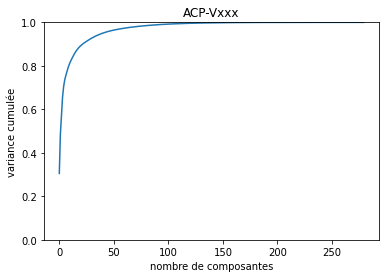

In [ ]:
train,pca = PCA_change(train, Vxx.columns,n_components=Vxx.shape[1], prefix='PCA_V_',rand_seed=4)
x=pca.explained_variance_ratio_
# dans ce premier temps on a laissé le nombre de composante par défaut aux nombre de colonnes en entrée.ce résulat est le % de la variance expliquée, 
#si ce % est suffisament grand on va dire kue cette composante explique bien la majorité de l'information  qui se trouve dans la variable d'entrée.
#Afficher le cumulé du % de var expli pour décider du nombre de composantes principale à garder, danc ce cas on garde 30 à 50 maximum 
fig, ax =plt.subplots(figsize=(6,4))
ax.plot( np.cumsum(x))
ax.set(xlabel="nombre de composantes", ylabel="variance cumulée", title="ACP-Vxxx", ylim=(0,1),)


**Exécuter ce code pour n_component = 100** 

In [ ]:
train,pca = PCA_change(train, Vxx.columns,n_components=100, prefix='PCA_V_',rand_seed=4)

In [ ]:
Vxx = test.loc[:,"V1":"V321"]  
test,pca = PCA_change(test, Vxx.columns,n_components=100, prefix='PCA_V_',rand_seed=4)

## **Modelisation**

### **Decision Tree**

**Decision Tree avec class_weight= balanced sans réglage d'hyperparamètres0.605**

In [ ]:

Y = train["isFraud"]
X = train.drop(columns='isFraud')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45)

In [ ]:
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state = 42)
base_tree.fit(X_train, Y_train)


base_tree_train_predict = base_tree.predict_proba(X_train)
base_tree_test_predict = base_tree.predict_proba(X_test)

print('base random forest train auc:', roc_auc_score(Y_train, base_tree_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_tree_test_predict[:,1]))

base random forest train auc: 1.0
base random forest test auc: 0.7148519107400491


In [ ]:
Y_final = base_tree.predict_proba(test)
submission_Tree = pd.DataFrame({'TransactionID':test['TransactionID'],'isFraud': Y_final[:,1]})


In [ ]:
filename = 'final8.csv'
submission_Tree.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: final8.csv


**Decision Tree avec class_weight= balanced avec réglage d'hyperparamètres 0.831675**

In [ ]:

Y = train["isFraud"]
X = train.drop(columns='isFraud')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45)

In [ ]:
# Function to measure the quality of a split
criterion = ['gini', 'entropy']
# Strategy used to choose the split at each node, random selects a set of features randomly and splits,
splitter = ['best', 'random']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 210, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# The number of features to consider when looking for the best split
max_features = ['auto', 'log2', None]
# Maximum number of leaf nodes
max_leaf_nodes = [int(x) for x in np.linspace(10, 210, num = 11)]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 , 12000, 15000, None]
# Split threshold of a decrease of the impurity
min_impurity_decrease = [0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.02]
# Complexity parameter used for Minimal Cost-Complexity Pruning
ccp_alpha = [x for x in np.linspace(0, 0.05, num = 11)]
# Create the random grid
random_grid = {'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha': ccp_alpha}

# pprint(random_grid)

In [ ]:
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state = 42)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune: base_tree
# Random search of parameters with auc_roc scoring, using 3 fold stratified cross validation,
skf = StratifiedKFold(n_splits=3, random_state=42)
# search across 60 different combinations, and use all available cores
tree_random = RandomizedSearchCV(estimator = base_tree, param_distributions = random_grid, n_iter = 60, cv = skf, scoring = 'roc_auc', verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
tree_random.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf...
                                        'max_leaf_nodes': [10, 30, 50, 70,

In [ ]:
best_random_tree_train_predict = tree_random.predict_proba(X_train)
best_random_tree_test_predict = tree_random.predict_proba(X_test)
print('best random tree train auc:', roc_auc_score(Y_train, best_random_tree_train_predict[:,1]))
print('best random tree test auc:', roc_auc_score(Y_test, best_random_tree_test_predict[:,1]))

best random tree train auc: 0.8224246259854169
best random tree test auc: 0.8277030415985582


In [ ]:
Y_final = tree_random.predict_proba(test)

In [ ]:
submission_tree = pd.DataFrame({'TransactionID':test['TransactionID'],'isFraud': Y_final[:,1]})

In [ ]:
filename = 'final10.csv'
submission_tree.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: final10.csv


**Decision Tree avec Resample sans réglage d'hyperparamètres 0,693844**

In [ ]:

# concatenate training data back together
# separate minority and majority class
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27)
# combine minority and downsampled majority
train = pd.concat([not_fraud_downsampled, fraud])    # Concatenation
# let's check the classes counts
train.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

In [ ]:

Y = train["isFraud"]
X = train.drop(columns='isFraud')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45)

In [ ]:
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state = 42)
base_tree.fit(X_train, Y_train)


base_tree_train_predict = base_tree.predict_proba(X_train)
base_tree_test_predict = base_tree.predict_proba(X_test)

print('base random forest train auc:', roc_auc_score(Y_train, base_tree_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_tree_test_predict[:,1]))

base random forest train auc: 1.0
base random forest test auc: 0.7449588643329569


In [ ]:
Y_final = base_tree.predict_proba(test)
submission_Tree2 = pd.DataFrame({'TransactionID':test['TransactionID'],'isFraud': Y_final[:,1]})


In [ ]:
filename = 'final9.csv'
submission_Tree2.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: final9.csv


**Decision Tree avec Resample avec réglage d'hyperparamètres 0,839628**

In [ ]:

# concatenate training data back together
# separate minority and majority class
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27)
# combine minority and downsampled majority
train = pd.concat([not_fraud_downsampled, fraud])    # Concatenation
# let's check the classes counts
train.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

In [ ]:

Y = train["isFraud"]
X = train.drop(columns='isFraud')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45)

In [ ]:
# Function to measure the quality of a split
criterion = ['gini', 'entropy']
# Strategy used to choose the split at each node, random selects a set of features randomly and splits,
splitter = ['best', 'random']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 210, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# The number of features to consider when looking for the best split
max_features = ['auto', 'log2', None]
# Maximum number of leaf nodes
max_leaf_nodes = [int(x) for x in np.linspace(10, 210, num = 11)]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 , 12000, 15000, None]
# Split threshold of a decrease of the impurity
min_impurity_decrease = [0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.02]
# Complexity parameter used for Minimal Cost-Complexity Pruning
ccp_alpha = [x for x in np.linspace(0, 0.05, num = 11)]
# Create the random grid
random_grid = {'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha': ccp_alpha}

# pprint(random_grid)

In [ ]:
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state = 42)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune: base_tree
# Random search of parameters with auc_roc scoring, using 3 fold stratified cross validation,
skf = StratifiedKFold(n_splits=3, random_state=42)
# search across 60 different combinations, and use all available cores
tree_random = RandomizedSearchCV(estimator = base_tree, param_distributions = random_grid, n_iter = 60, cv = skf, scoring = 'roc_auc', verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
tree_random.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf...
                                        'max_leaf_nodes': [10, 30, 50, 70,

In [ ]:
best_random_tree_train_predict = tree_random.predict_proba(X_train)
best_random_tree_test_predict = tree_random.predict_proba(X_test)
print('best random tree train auc:', roc_auc_score(Y_train, best_random_tree_train_predict[:,1]))
print('best random tree test auc:', roc_auc_score(Y_test, best_random_tree_test_predict[:,1]))

best random tree train auc: 0.8211494760679858
best random tree test auc: 0.8183711754475644


In [ ]:
Y_final = tree_random.predict_proba(test)

In [ ]:
submission_tree4 = pd.DataFrame({'TransactionID':test['TransactionID'],'isFraud': Y_final[:,1]})

In [ ]:
filename = 'final12.csv'
submission_tree4.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: final12.csv


### **Random Forest**

**RandomForest avec class_weight="balanced" et sans réglage d'hyperparamètres 0.854356**

In [ ]:
Y=train["isFraud"]
X=train.drop(columns=["isFraud"])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45,stratify=Y)

In [ ]:
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
base_rf.fit(X_train, Y_train)
base_rf_train_predict = base_rf.predict_proba(X_train)
base_rf_test_predict = base_rf.predict_proba(X_test)

print('base random forest train auc:', roc_auc_score(Y_train, base_rf_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_rf_test_predict[:,1]))

base random forest train auc: 1.0
base random forest test auc: 0.9025413904520481


In [ ]:
RanForestBD=base_rf.predict_proba(test)[:,1] 

In [ ]:
FinalRBD = pd.DataFrame({'TransactionID':test['TransactionID'],'isFraud':RanForestBD})

In [ ]:
filename = 'FinalRBD.csv'

FinalRBD.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: FinalRBD.csv


**RandomForest avec class_weight="balanced" et réglage des hyperparamétres 0.887373**

In [ ]:
Y=train["isFraud"]
X=train.drop(columns=["isFraud"])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45,stratify=Y)

In [ ]:
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)


In [ ]:
# Number of trees in random forest
n_estimators = [10,20,30]
# Function to measure the quality of a split
criterion = ['gini', 'entropy']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [20,30,40]
# The number of features to consider when looking for the best split
max_features = [0.7,'auto', 'log2', None]
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features
               
              }

# pprint(random_grid)

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune: base_rf
# Random search of parameters with auc_roc scoring, using 3 fold stratified cross validation,
skf = StratifiedKFold(n_splits=3, random_state=42)
# search across 60 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = base_rf, param_distributions = random_grid, n_iter = 60, 
                               cv = skf, scoring = 'roc_auc', verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_sample...
                   ii

In [ ]:
print(rf_random.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 80, 'max_features': 0.7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 20, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
rf_random = RandomForestClassifier(bootstrap= True, ccp_alpha= 0.0, class_weight='balanced', criterion= 'gini', max_depth= 80, max_features= 0.7, max_leaf_nodes= None, max_samples= None, min_impurity_decrease= 0.0, min_impurity_split= None, min_samples_leaf= 20, min_samples_split= 5, min_weight_fraction_leaf= 0.0, n_estimators= 30, n_jobs= None, oob_score= False, random_state= 42, verbose= 0, warm_start= False)
rf_random.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=80, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
base_rf_train_predict = rf_random.predict_proba(X_train)
base_rf_test_predict = rf_random.predict_proba(X_test)

print('base random forest train auc:', roc_auc_score(Y_train, base_rf_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_rf_test_predict[:,1]))

base random forest train auc: 0.9957077369610208
base random forest test auc: 0.9114323529288872


In [ ]:
RanForestBR=rf_random.predict_proba(test)[:,1] 

In [ ]:
FinalRBR = pd.DataFrame({'TransactionID':test['TransactionID'],'isFraud':RanForestBR})

In [ ]:
filename = 'FinalRBR.csv'

FinalRBR.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: FinalRBR.csv


**RandomForest avec Resample et sans réglage des hyperparamétres 0.892719**

In [ ]:
from sklearn.utils import resample
# concatenate training data back together
# separate minority and majority class
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27)
# combine minority and downsampled majority
train = pd.concat([not_fraud_downsampled, fraud])    # Concatenation
# let's check the classes counts
train.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

In [ ]:
Y=train["isFraud"]
X=train.drop(columns=["isFraud"])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
base_rf= RandomForestClassifier(random_state=42)

In [ ]:
base_rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:

base_rf_train_predict = base_rf.predict_proba(X_train)
base_rf_test_predict = base_rf.predict_proba(X_test)

print('base random forest train auc:', roc_auc_score(Y_train, base_rf_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_rf_test_predict[:,1]))

base random forest train auc: 1.0
base random forest test auc: 0.8910293157742585


In [ ]:
RanForestRSR=base_rf.predict_proba(test)[:,1] 

In [ ]:
FinalRSR = pd.DataFrame({'TransactionID':test['TransactionID'],'isFraud':RanForestRSR})

In [ ]:
filename = 'FinalRSR.csv'

FinalRSR.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: FinalRSR.csv


**RandomForest avec Resample et réglage des hyperparamètres 0.901086**

In [ ]:
# concatenate training data back together
# separate minority and majority class
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27)
# combine minority and downsampled majority
train = pd.concat([not_fraud_downsampled, fraud])    # Concatenation
# let's check the classes counts
train.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

In [ ]:
Y=train["isFraud"]
X=train.drop(columns=["isFraud"])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
base_rf= RandomForestClassifier(random_state=42)

In [ ]:
# Number of trees in random forest
n_estimators = [10,20,30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [20,30,40]
# The number of features to consider when looking for the best split
max_features = [0.7,'auto', 'log2', None]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features

}
# pprint(random_grid)

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune: base_rf
# Random search of parameters with auc_roc scoring, using 3 fold stratified cross validation,
skf = StratifiedKFold(n_splits=3, random_state=42)
# search across 60 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = base_rf, param_distributions = random_grid, n_iter = 60, 
                               cv = skf, scoring = 'roc_auc', verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 36 is smaller than n_iter=60. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_spli...
                     

In [ ]:
base_rf_train_predict = rf_random.predict_proba(X_train)
base_rf_test_predict = rf_random.predict_proba(X_test)
print('base random forest train auc:', roc_auc_score(Y_train, base_rf_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_rf_test_predict[:,1]))

base random forest train auc: 0.9560577953634031
base random forest test auc: 0.8891405530362251


In [ ]:
print(rf_random.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 20, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
rf_random= RandomForestClassifier(bootstrap= True, ccp_alpha= 0.0, class_weight=None, criterion= 'gini', max_depth= None, max_features= 0.7, max_leaf_nodes= None, max_samples= None, min_impurity_decrease=0.0, min_impurity_split= None, min_samples_leaf= 20,min_samples_split= 2, min_weight_fraction_leaf= 0.0, n_estimators=30, n_jobs= None, oob_score= False, random_state= 42, verbose= 0, warm_start= False)
rf_random.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
FinalRAR=rf_random.predict_proba(test)[:,1] 

In [ ]:
RanForestRAR = pd.DataFrame({'TransactionID':test['TransactionID'],'isFraud':FinalRAR})

In [ ]:
filename = 'FinalRAR.csv'

RanForestRAR.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: FinalRAR.csv
